# Numerical Solvers for Delay Differential Equations

@[Chaoming Wang](https://github.com/chaoming0625)

**Delay differential equations (DDE)** differ from [ordinary differential equations](./ode_numerical_solvers.ipynb) in that the derivative at any time depends on the solution at prior times. The simplest **constant delay** equations have the form

$$
y'(t) = f(t, y(t), y(t-\tau_1), y(t-\tau_2),\ldots, y(t-\tau_k))
$$

where the time delays (lags) $\tau_j$ are positive constants. 

For **neutral type DDE** delays appear in derivative terms, 

$$
y'(t) = f(t, y(t), y'(t-\tau_1), y'(t-\tau_2),\ldots, y'(t-\tau_k))
$$

More generally, **state dependent** delays may depend on the solution, that is $\tau_i = \tau_i (t,y(t))$. 

In the section, we are going to talk about the suuport of BrainPy for DDE numerical integrations. 

In [1]:
import brainpy as bp
import brainpy.math as bm

import matplotlib.pyplot as plt

## Delay variables

For an ODE system, the numerical methods need to know its initial condition $y(t_0)=y_0$ and its derivative rule $y'(t_0) = y'_0$. However, for DDEs, it is not enough to give a set of initial values for the function and its derivatives at $t_0$, but one must give a set of functions to provide the historical values for  $t_0 - max(\tau) \leq t \leq t_0$. 

Therefore, you need some delay variables to wrap the variable delays. 

BrainPy provides several kinds of delay variables: 

<!-- - [brainpy.dyn.ConstantDelay](../apis/auto/dyn/generated/brainpy.dyn.base.ConstantDelay.rst) -->
- [brainpy.math.TimeDelay](../apis/auto/math/generated/brainpy.math.delay_vars.TimeDelay.rst)
- [brainpy.math.NeutralDelay](../apis/auto/math/generated/brainpy.math.delay_vars.NeutralDelay.rst)

All of these can be used for defining delay differential equations. ``brainpy.math.TimeDelay`` can be used to define delay variables which depend on states, and ``brainpy.math.NeutralDelay`` is used to define delay variables which depend on the derivative.

In [2]:
d = bm.TimeDelay(bm.zeros(1), delay_len=10, dt=1, t0=0, before_t0=lambda t: t)

In [3]:
d(0.)

DeviceArray([0.], dtype=float32)

In [4]:
d(-0.5)

DeviceArray([-0.5], dtype=float32)

Request a time beyond $(max\_delay, t_0)$ will cause an error. 

In [5]:
try:
    d(0.1)
except Exception as e:
    print(e)

## Supportted numerical methods

Numerical integration for delay differential equations supports multiple explicit Runge-Kutta algorithms. Users can check the details of them through the [documentation](../apis/integrators/DDE.rst). 

In [6]:
bp.dde.get_supported_methods()

['euler',
 'midpoint',
 'heun2',
 'ralston2',
 'rk2',
 'rk3',
 'heun3',
 'ralston3',
 'ssprk3',
 'rk4',
 'ralston4',
 'rk4_38rule']

These methods can be used in the setting of ``brainpy.ddeint(fun, method)`` function to specify the numerical method you want to choose. 

## Example #1: First-order DDE with one constant delay and a constant initial history function

Let the following DDE be given:

$$
y'(t)=-y(t-1)
$$

where the delay is 1 s. the example compares the solutions of three different cases using three different constant history functions: 

- Case #1: $\phi(t)=-1$
- Case #2: $\phi(t)=0$
- Cas3 #3: $\phi(t)=1$

In [7]:
def equation(x, t, xdelay):
    return -xdelay(t-1)

case1_delay = bm.TimeDelay(bm.zeros((1,)), 1., before_t0=-1., interp_method='round')
case2_delay = bm.TimeDelay(bm.zeros((1,)), 1., before_t0=0., interp_method='round')
case3_delay = bm.TimeDelay(bm.zeros((1,)), 1., before_t0=1., interp_method='round')

In [8]:
def ddeint(duration, eq, args=None,
           state_delays=None, neutral_delays=None,
           monitors=('x',), method='euler', dt=0.1, inits=None):
    dde = bp.ddeint(eq, state_delays=state_delays, neutral_delays=neutral_delays, method=method)
    runner = bp.integrators.IntegratorRunner(dde, args=args, monitors=monitors, dt=dt, inits=inits)
    runner.run(duration)
    return runner.mon

In [9]:
case1 = ddeint(20., equation,
               args={'xdelay': case1_delay},
               state_delays={'x': case1_delay}) # delay for variable "x"
case2 = ddeint(20., equation, args={'xdelay': case2_delay}, state_delays={'x': case2_delay})
case3 = ddeint(20., equation, args={'xdelay': case3_delay}, state_delays={'x': case3_delay})

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

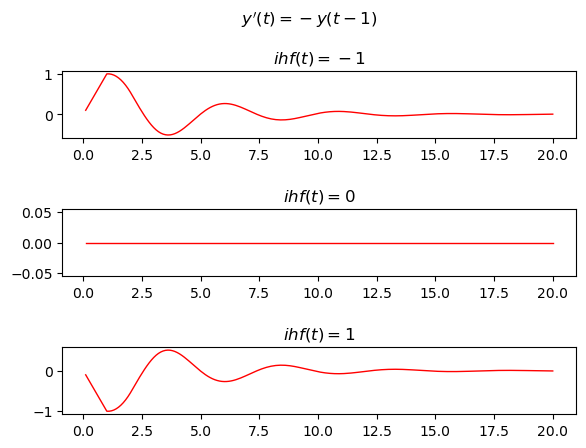

In [10]:
fig, axs = plt.subplots(3, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y'(t)=-y(t-1)$")

axs[0].plot(case1.ts, case1.x, color='red', linewidth=1)
axs[0].set_title('$ihf(t)=-1$')
 
axs[1].plot(case2.ts, case2.x, color='red', linewidth=1)
axs[1].set_title('$ihf(t)=0$')

axs[2].plot(case3.ts, case3.x, color='red', linewidth=1)
axs[2].set_title('$ihf(t)=1$')

plt.show()

## Example #2: First-order DDE with one constant delay and a non constant initial history function

Let the following DDE be given:

$$
y'(t)=-y(t-2)
$$

where the delay is 2 s; the example compares the solutions of four different cases using two different non constant history functions and two different intervals of $t$:

- Case #1: $\phi(t)=e^{-t} - 1, t \in [0, 4]$
- Case #2: $\phi(t)=e^{t} - 1, t \in [0, 4]$
- Case #3: $\phi(t)=e^{-t} - 1, t \in [0, 60]$
- Case #4: $\phi(t)=e^{t} - 1, t \in [0, 60]$

In [11]:
def eq(x, t, xdelay): 
    return -xdelay(t-2)

delay1 = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(-t)-1, dt=0.01, interp_method='round')
delay2 = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(t)-1, dt=0.01, interp_method='round')
delay3 = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(-t)-1, dt=0.01, interp_method='round')
delay4 = bm.TimeDelay(bm.zeros(1), 2., before_t0=lambda t: bm.exp(t)-1, dt=0.01, interp_method='round')

In [12]:
case1 = ddeint(4., eq, args={'xdelay': delay1}, state_delays={'x': delay1}, dt=0.01)
case2 = ddeint(4., eq, args={'xdelay': delay2}, state_delays={'x': delay2}, dt=0.01)
case3 = ddeint(60., eq, args={'xdelay': delay3}, state_delays={'x': delay3}, dt=0.01)
case4 = ddeint(60., eq, args={'xdelay': delay4}, state_delays={'x': delay4}, dt=0.01)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

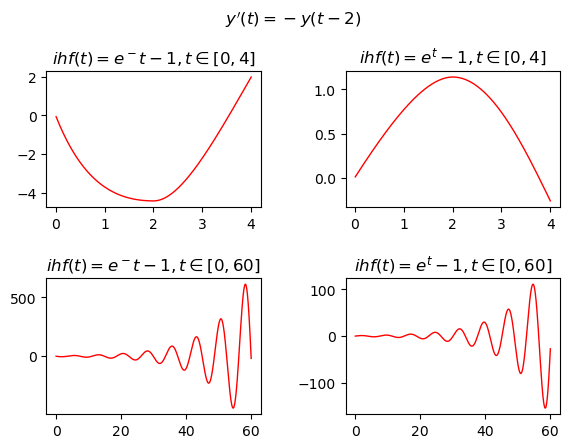

In [13]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y'(t)=-y(t-2)$")

axs[0, 0].plot(case1.ts, case1.x, color='red', linewidth=1)
axs[0, 0].set_title('$ihf(t)=e^-t - 1, t \in [0, 4]$')

axs[0, 1].plot(case2.ts, case2.x, color='red', linewidth=1)
axs[0, 1].set_title('$ihf(t)=e^t - 1, t \in [0, 4]$')

axs[1, 0].plot(case3.ts, case3.x, color='red', linewidth=1)
axs[1, 0].set_title('$ihf(t)=e^-t - 1, t \in [0, 60]$')

axs[1, 1].plot(case4.ts, case4.x, color='red', linewidth=1)
axs[1, 1].set_title('$ihf(t)=e^t - 1, t \in [0, 60]$')

plt.show()

## Example #3: First-order DDE with two constant delays and a constant initial history function

Let the following DDE be given:

$$
y'(t)=-y(t - 1) + 0.3 y(t - 2)
$$

where the delays are two and are both constants equal to 1s and 2s respectively; The initial historical function is also constant and is $\phi(t)=1$.

In [14]:
def eq(x, t): 
    return -delay(t-1) + 0.3*delay(t-2)

delay = bm.TimeDelay(bm.ones(1), 2., before_t0=1., dt=0.01, interp_method='round')
mon = ddeint(10., eq, inits=[1.], state_delays={'x': delay}, dt=0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

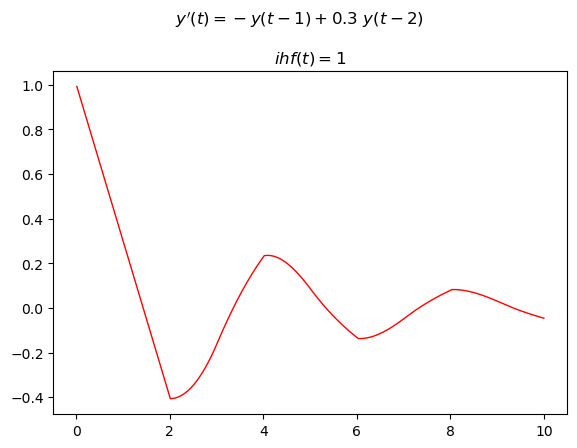

In [15]:
fig, axs = plt.subplots(1, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y'(t)=-y(t-1) + 0.3\ y(t-2)$")

axs.plot(mon.ts, mon.x, color='red', linewidth=1)
axs.set_title('$ihf(t)=1$')

plt.show()

## Example #4: System of two first-order DDEs with one constant delay and two constant initial history functions

Let the following system of DDEs be given:

$$
\begin{cases}
    y_1'(t) = y_1(t) y_2(t-0.5)
    \\
    y_2'(t) = y_2(t) y_1(t-0.5)
\end{cases}
$$

where the delay is only one, constant and equal to 0.5 s and the initial historical functions are also constant; for what we said at the beginning of the post these must be two, in fact being the order of the system of first degree you need one for each unknown and they are: $y_1(t)=1, y_2(t)=-1$. 

In [16]:
def eq(x, y, t):
    dx = x * ydelay(t-0.5)
    dy = y * xdelay(t-0.5)
    return dx, dy

xdelay = bm.TimeDelay(bm.ones(1), 0.5, before_t0=1., dt=0.01, interp_method='round')
ydelay = bm.TimeDelay(-bm.ones(1), 0.5, before_t0=-1., dt=0.01, interp_method='round')

mon = ddeint(3., eq, inits=[1., -1], state_delays={'x': xdelay, 'y': ydelay}, 
             dt=0.01, monitors=['x', 'y'])

  0%|          | 0/300 [00:00<?, ?it/s]

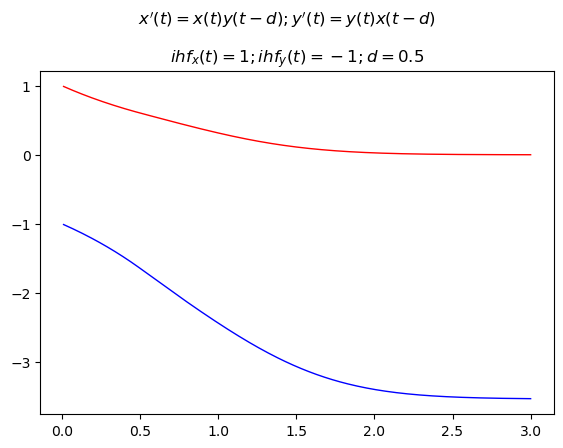

In [17]:
fig, axs = plt.subplots(1, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$x'(t)=x(t) y(t-d); y'(t)=y(t) x(t-d)$")

axs.plot(mon.ts, mon.x.flatten(), color='red', linewidth=1)
axs.plot(mon.ts, mon.y.flatten(), color='blue', linewidth=1)
axs.set_title('$ihf_x(t)=1; ihf_y(t)=-1; d=0.5$')

plt.show()

## Example #5: Second-order DDE with one constant delay and two constant initial history functions

Let the following DDE be given:

$$
y(t)'' = -y'(t) - 2y(t) - 0.5 y(t-1)
$$

where the delay is only one, constant and equal to 1 s. Since the DDE is second order, in that the second derivative of the unknown function appears, the historical functions must be two, one to give the values of the unknown $y(t)$ for $t <= 0$,  and one and one to provide the value of the first derivative $y'(t)$ also for $t <= 0$. 

In this example they are the following two constant functions: $y(t)=1, y'(t)=0$.

Due to the properties of the second-order equations, the given DDE is equivalent to the following system of first-order equations:

$$
\begin{cases}
    y_1'(t) = y_2(t)
    \\
    y_2'(t) = -y_1'(t) - 2y_1(t) - 0.5 y_1(t-1)
\end{cases}
$$

and so the implementation falls into the case of the previous example of systems of first-order equations.

In [18]:
def eq(x, y, t):
    dx = y
    dy = -y - 2*x - 0.5*xdelay(t-1)
    return dx, dy

xdelay = bm.TimeDelay(bm.ones(1), 1., before_t0=1., dt=0.01, interp_method='round')
mon = ddeint(16., eq, inits=[1., 0.], state_delays={'x': xdelay}, monitors=['x', 'y'], dt=0.01)

  0%|          | 0/1600 [00:00<?, ?it/s]

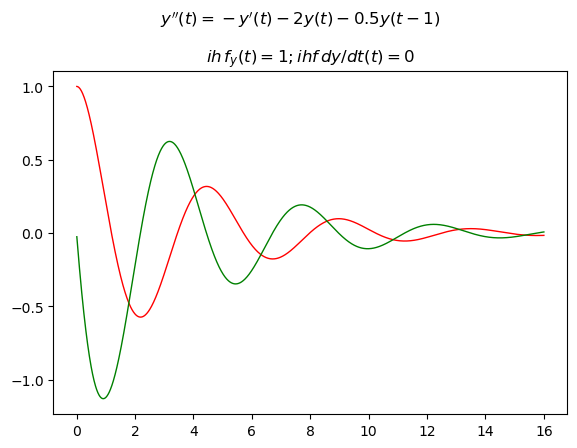

In [19]:
fig, axs = plt.subplots(1, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y''(t)=-y'(t) - 2 y(t) - 0.5 y(t-1)$")
axs.plot(mon.ts, mon.x[:,0], color='red', linewidth=1)
axs.plot(mon.ts, mon.y[:,0], color='green', linewidth=1)
axs.set_title('$ih \, f_y(t)=1; ihf\,dy/dt(t)=0$')

plt.show()

## Example #6: First-order DDE with one non constant delay and a constant initial history function

Let the following DDE be given:

$$
y'(t)=y(t-\mathrm{delay}(y, t))
$$

where the delay is not constant and is given by the function $\mathrm{delay}(y, t)=|\frac{1}{10} t y(\frac{1}{10} t)|$, the example compares the solutions of two different cases using two different constant history functions:

- Case #1: $\phi(t)=-1$
- Case #2: $\phi(t)=1$

In [20]:
def eq(x, t, xdelay):
    delay = abs(t*xdelay(t - 0.9 * t)/10) # a tensor with (1,)
    delay = delay[0]
    return xdelay(t-delay)

```{note}

Note here we do not kwon the maximum lenght of the delay. Therefore, we can declare a fixed length delay variable with the ``delay_len`` equal to or even bigger than the running duration. 
```

In [21]:
delay1 = bm.TimeDelay(bm.ones(1), 30., before_t0=-1, dt=0.01)
delay2 = bm.TimeDelay(-bm.ones(1), 30., before_t0=1, dt=0.01)

In [22]:
case1 = ddeint(30., eq, args={'xdelay': delay1}, state_delays={'x': delay1}, dt=0.01)
case2 = ddeint(30., eq, args={'xdelay': delay2}, state_delays={'x': delay2}, dt=0.01)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

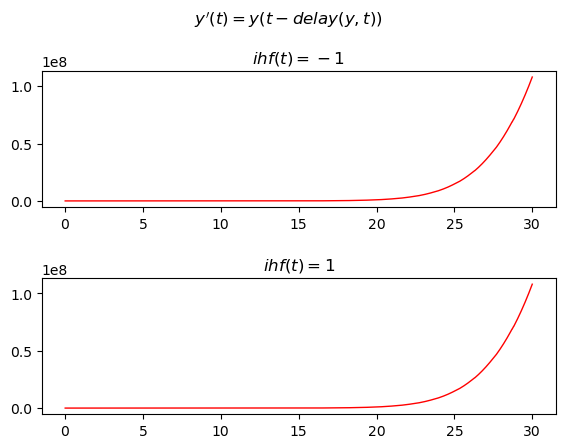

In [23]:
fig, axs = plt.subplots(2, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y'(t)=y(t-delay(y, t))$")

axs[0].plot(case1.ts, case1.x, color='red', linewidth=1)
axs[0].set_title('$ihf(t)=-1$')

axs[1].plot(case1.ts, case1.x, color='red', linewidth=1)
axs[1].set_title('$ihf(t)=1$')

plt.show()

## Acknowledgement

This tutorial is highly inspired from the work of Ettore Messina [1].

- [1] Computational Mindset by Ettore Messina, [Solving delay differential equations using numerical methods in Python](https://computationalmindset.com/en/mathematics/solving-delay-differential-equations-in-python-using-numerical-methods.html)